In [1]:
#Install packages for pressure devices
import sys
from email.header import UTF8
sys.path.append('./DLL64')
sys.path.append('./Elveflow64.py')
from ctypes import *
from array import array
from Elveflow64 import *
import time
import matplotlib.pyplot as plt
import numpy as np

Instr_ID = c_int32()

In [2]:
#Input the setup type - Ensure no other instances are running
def pressure_init():
    print("Instrument name and regulator types are hardcoded in the Python script")
    #Insert Machine Code HERE
    error = OB1_Initialization('01EA53FD'.encode('ascii'),2,2,2,2,byref(Instr_ID)) 
    print('error:%d' % error)
    print("OB1 ID: %d" % Instr_ID.value)

pressure_init()

Instrument name and regulator types are hardcoded in the Python script
error:0
OB1 ID: 0


In [3]:
error=OB1_Add_Sens(Instr_ID, 1, 5, 1, 0, 7, 0)
#error=OB1_Add_Sens(Instr_ID, 2, 4, 1, 0, 7, 0) #marcus sensor
error=OB1_Add_Sens(Instr_ID, 2, 5, 1, 0, 7, 0)
#InstrID, Sensor Type (5-1000ul/min), Analogue(0), Calibration (H20 - 0)
print('error add digit flow sensor:%d' % error)

error add digit flow sensor:0


In [4]:
Calib = (c_double*1000)()
def pressure_calib(answer): # Always define array this way, calibration should have 1000 elements
    while True:
        Calib_path = './Calib.txt'
        if answer == 'default':
            error = Elveflow_Calibration_Default (byref(Calib),1000)
            print("Default Calibration taken")
            break
            
        if answer == 'load':
            error = Elveflow_Calibration_Load (Calib_path.encode('ascii'), byref(Calib), 1000)
            break
            
        if answer == 'new':
            OB1_Calib (Instr_ID.value, Calib, 1000)
            error = Elveflow_Calibration_Save(Calib_path.encode('ascii'), byref(Calib), 1000)
            print('Calib saved in %s' % Calib_path.encode('ascii'))
            break

pressure_calib('default')

Default Calibration taken


In [5]:
def set_pressure(set_channel,set_pressure):
    set_channel=int(set_channel) # convert to int
    set_channel=c_int32(set_channel) # convert to c_int32
    set_pressure=float(set_pressure) 
    set_pressure=c_double(set_pressure) # convert to c_double
    error=OB1_Set_Press(Instr_ID.value, set_channel, set_pressure, byref(Calib),1000) 
    return error 

set_pressure(1,100)
set_pressure(2,100)

0

In [6]:
def get_pressure_data(press_channel):
    set_channel=c_int32( int(press_channel) ) # convert to c_int32
    get_pressure=c_double()
    error=OB1_Get_Press(Instr_ID.value, set_channel, 1, byref(Calib),byref(get_pressure), 1000) # Acquire_data=1 -> read all the analog values
    return get_pressure.value, error

print(get_pressure_data(1))
print(get_pressure_data(2))
#get_pressure_data(3)
#get_pressure_data(4)

(107.08713519999999, 0)
(105.04679139999999, 0)


In [7]:
def get_sensor_data(sensor_channel):
    data_sens=c_double()
    set_channel=int(sensor_channel) # convert to int
    set_channel=c_int32(sensor_channel) # convert to c_int32
    error=OB1_Get_Sens_Data(Instr_ID.value,set_channel, 1,byref(data_sens)) # Acquire_data=1 -> read all the analog values
    return data_sens.value, error
print(get_sensor_data(1))
print(get_sensor_data(2))
print(get_sensor_data(3))

(3.7241379310344827, 0)
(290.58620689655174, 0)
(0.0, 0)


Control P - 1 30
Flow rate - 1 -4.068965517241379
Actual P - 31.3471002 
----
Control P - 2 30
Flow rate - 2 -38.206896551724135
Actual P - 33.078300999999996 
----
Control P - 1 30
Flow rate - 1 -51.13793103448276
Actual P - 34.5621874 
----
Control P - 2 30
Flow rate - 2 -44.206896551724135
Actual P - 34.624016 
----
Control P - 1 30
Flow rate - 1 -29.137931034482758
Actual P - 34.624016 
----
Control P - 2 30
Flow rate - 2 -28.482758620689655
Actual P - 34.5621874 
----
Control P - 1 30
Flow rate - 1 -26.586206896551722
Actual P - 34.5003588 
----
Control P - 2 30
Flow rate - 2 -26.482758620689655
Actual P - 34.624016 
----
Control P - 1 30
Flow rate - 1 -25.896551724137932
Actual P - 34.624016 
----
Control P - 2 30
Flow rate - 2 -25.96551724137931
Actual P - 34.5621874 
----
Control P - 1 30
Flow rate - 1 -25.586206896551722
Actual P - 34.624016 
----
Control P - 2 30
Flow rate - 2 -25.689655172413794
Actual P - 34.5621874 
----
Control P - 1 30
Flow rate - 1 -25.344827586206897
A

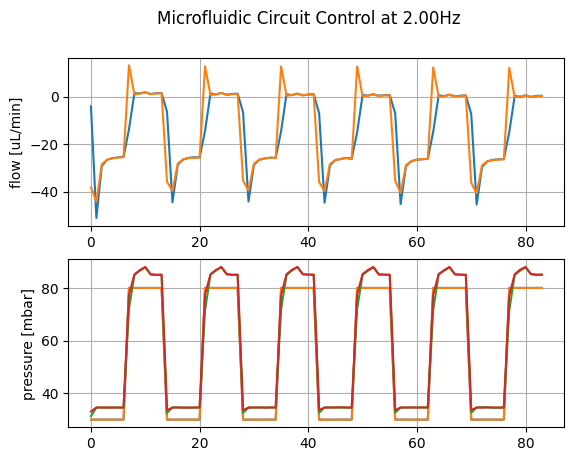

In [8]:
#Constant Pressure

period = 0.5
experiment_t = 3
start_t = time.time()
last_t = start_t
active_channels = [1,2]
ref_pressure = [30,80,30,80,30,80,30,80,30,80,30,80]
adjustment = 0

flow_list, cont_pressure_list, real_pressure_list = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]

for press in ref_pressure:
    start_t = time.time()
    last_t = start_t
    while True:
        for i, channel in enumerate(active_channels):
            print("Control P -",channel, press)
            cont_pressure_list[i].append(press)
            set_pressure(channel,press)
            fr = get_sensor_data(i)[0]
            flow_list[i].append(fr)
            print("Flow rate -",channel,fr)
            pr = get_pressure_data(1)[0]  
            real_pressure_list[i].append(pr)  
            print("Actual P -", pr,"\n----")
        if (time.time() - start_t) > experiment_t:
            break
        # Wait until desired period time
        sleep_t = period - (time.time() - last_t)
        if sleep_t > 0:
            time.sleep( sleep_t )
        last_t = time.time() # And update the last time 


plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
plt.subplot(2,1,1)
plt.plot( flow_list[0] )
plt.plot( flow_list[1] )
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list[0])
plt.plot(cont_pressure_list[1])
plt.plot(real_pressure_list[0])
plt.plot(real_pressure_list[1])
plt.ylabel('pressure [mbar]')
plt.show()

In [9]:
period = 0.5
experiment_t = 30
start_t = time.time()
last_t = start_t
active_channels = [1,2]
set_FR = [50,50]
K_p = 0.05 #Tune the proportional component
K_i = 0.01 #Tune the integral component 

flow_list, fr, pr_control, real_pressure_list = [[],[],[],[]],[[],[],[],[]],[0,0,0,0],[[],[],[],[]]
I = [0,0,0,0]

while True:
    for i, channel in enumerate(active_channels):
        print(i,channel)
        fr[i] = get_sensor_data(channel)[0]
        #flow_list.append(fr)
        print("Flow Rate Channel",channel,"is",fr[i])
        fr_error = fr[i]-set_FR[i]
        pr = get_pressure_data(channel)[0]  
        #real_pressure_list.append(pr)  
        I[i] = I[i] + K_i*fr_error*(period)
        adjustment =  fr_error*K_p + I[i]
        print("Kp", fr_error*K_p,"Ki", I[i])
        pr_control[i] = pr_control[i] - adjustment 
        print("Set Pressure",channel,"is",pr_control[i])
        #cont_pressure_list.append(pr_control)
        set_pressure(channel,pr_control[i])
        print("Real Pressure",channel,"is",get_pressure_data(channel)[0])
    if (time.time() - start_t) > experiment_t:
        break
    # Wait until desired period time
    sleep_t = period - (time.time() - last_t)
    if sleep_t > 0:
        time.sleep( sleep_t )
    last_t = time.time() # And update the last time
    
set_pressure(1,0)
set_pressure(2,0)
for i, channel in enumerate(active_channels):
    plt.rcParams['axes.grid'] = True
    fig=plt.figure()
    fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
    plt.subplot(2,1,1)
    plt.plot( flow_list )
    plt.ylabel('flow [uL/min]')
    plt.subplot(2,1,2)
    plt.plot(cont_pressure_list)
    plt.plot(real_pressure_list)
    plt.ylabel('pressure [mbar]')
    plt.show()


0 1
Flow Rate Channel 1 is -22.79310344827586
Kp -3.639655172413793 Ki -0.07279310344827587
Set Pressure 1 is 3.712448275862069
Real Pressure 1 is 34.5621874
1 2
Flow Rate Channel 2 is -1.0
Kp -2.5500000000000003 Ki -0.051000000000000004
Set Pressure 2 is 2.6010000000000004
Real Pressure 2 is 34.00573
0 1
Flow Rate Channel 1 is -116.55172413793103
Kp -8.327586206896553 Ki -0.23934482758620695
Set Pressure 1 is 12.27937931034483
Real Pressure 1 is 20.2179522
1 2
Flow Rate Channel 2 is -60.62068965517241
Kp -5.531034482758621 Ki -0.16162068965517243
Set Pressure 2 is 8.293655172413793
Real Pressure 2 is 17.5593224
0 1
Flow Rate Channel 1 is -173.68965517241378
Kp -11.184482758620689 Ki -0.46303448275862075
Set Pressure 1 is 23.92689655172414
Real Pressure 1 is 20.1561236
1 2
Flow Rate Channel 2 is -162.06896551724137
Kp -10.60344827586207 Ki -0.3736896551724138
Set Pressure 2 is 19.270793103448277
Real Pressure 2 is 17.4974938
0 1
Flow Rate Channel 1 is -151.93103448275863
Kp -10.0965517

KeyboardInterrupt: 



Set Flow rate 100 


Ch1-FR 0.14 Ch2-FR 233.38 Ch3-FR 0.00
Ch1-FR -119.69 Ch2-FR 81.86 Ch3-FR 0.00
Ch1-FR -109.21 Ch2-FR 12.83 Ch3-FR 0.00
Ch1-FR -93.00 Ch2-FR -9.59 Ch3-FR 0.00
Ch1-FR -86.79 Ch2-FR -19.62 Ch3-FR 0.00
Ch1-FR -84.21 Ch2-FR -24.38 Ch3-FR 0.00
Ch1-FR -83.17 Ch2-FR -27.24 Ch3-FR 0.00
Ch1-FR -82.48 Ch2-FR -29.21 Ch3-FR 0.00
Ch1-FR -81.90 Ch2-FR -30.59 Ch3-FR 0.00
Ch1-FR -81.34 Ch2-FR -31.69 Ch3-FR 0.00
Ch1-FR -81.38 Ch2-FR -32.45 Ch3-FR 0.00
Ch1-FR -81.14 Ch2-FR -33.17 Ch3-FR 0.00
Ch1-FR -80.83 Ch2-FR -33.52 Ch3-FR 0.00
Ch1-FR -80.62 Ch2-FR -33.93 Ch3-FR 0.00
Ch1-FR -80.24 Ch2-FR -35.66 Ch3-FR 0.00
Ch1-FR -51.93 Ch2-FR -51.10 Ch3-FR 0.00
Ch1-FR -16.38 Ch2-FR -71.10 Ch3-FR 0.00
Ch1-FR -9.28 Ch2-FR -79.90 Ch3-FR 0.00
Ch1-FR -7.21 Ch2-FR -86.07 Ch3-FR 0.00
Ch1-FR -7.24 Ch2-FR -89.10 Ch3-FR 0.00
Ch1-FR -11.83 Ch2-FR -83.86 Ch3-FR 0.00
Ch1-FR -11.72 Ch2-FR -81.31 Ch3-FR 0.00
Ch1-FR -13.14 Ch2-FR -48.38 Ch3-FR 0.00
Ch1-FR -14.69 Ch2-FR -20.38 Ch3-FR 0.00
Ch1-FR -14.41 Ch2-FR -6

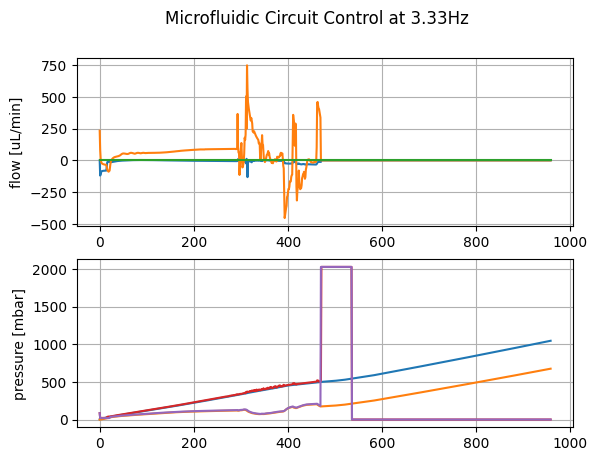

In [9]:
#

period = 0.3
experiment_t = 60
start_t = time.time()
last_t = start_t
active_channels = [1,2]
eqb_d = 10
col_t = 0
K_p = [0.05,0.05] #Tune the proportional component
K_i = 0.035 #Tune the integral component 
FlowScale = [100,30,50,80,100]

flow_list, fr, pr_control, cont_pressure_list, real_pressure_list = [[],[],[],[]],[[],[],[],[]],[0,0,0,0],[[],[],[],[]],[[],[],[],[]]
I = [0,0,0,0]
active_t = 120


for flow in FlowScale:
    print("\n\nSet Flow rate",flow,"\n\n")
    start_t = time.time()
    last_t = start_t
    collection = False
    active_t = 120
    t = 0
    fr_perc_error = [[],[],[],[]]
    while True:
        for i, channel in enumerate(active_channels):
            #Read Flow Rate
            fr[i] = get_sensor_data(channel)[0]
            flow_list[i].append(fr[i])
            fr_error = fr[i]-flow
            fr_perc_error[i].append(abs(fr_error/flow))
            #Read Pressure
            pr = get_pressure_data(channel)[0]
            real_pressure_list[i].append(pr) 
            #Calculate Correction
            I[i] = I[i] + K_i*fr_error*(period)
            adjustment =  fr_error*K_p[i] + I[i]
            pr_control[i] = pr_control[i] - adjustment 
            cont_pressure_list[i].append(pr_control[i])
            set_pressure(channel,pr_control[i])
        fr[2] = get_sensor_data(3)[0]
        flow_list[2].append(fr[2])
        print("Ch1-FR {:.2f}".format(fr[0]),"Ch2-FR {:.2f}".format(fr[1]),"Ch3-FR {:.2f}".format(fr[2]))

        if t > eqb_d*2:
            #print(np.max((fr_perc_error[i])[(t-eqb_d*2):t]))
            if np.max((fr_perc_error[i])[(t-eqb_d*2):t]) < 0.1 and collection == False:
                print(np.max((fr_perc_error[i])[(t-eqb_d*2):t]))
                print("Equilibriation time ",t/2,"s")
                print("Beginning Collection\n\n\n")
                #Move to well position
                collection = True
                start_t = time.time()
                active_t = col_t
            elif np.max((fr_perc_error[i])[(t-eqb_d*2):t]) > 0.1 and collection == True:
                print("Flow rate condition fail")

        if (time.time() - start_t) > active_t:
            break
        # Wait until desired period time
        sleep_t = period - (time.time() - last_t)
        if sleep_t > 0:
            time.sleep( sleep_t )
        last_t = time.time() # And update the last time 
        t = t+1
    
    
set_pressure(1,0)
set_pressure(2,0)
print(flow_list)
print(cont_pressure_list)
print(real_pressure_list,"\n")


plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
plt.subplot(2,1,1)
plt.plot(flow_list[0])
plt.plot(flow_list[1])
plt.plot(flow_list[2])
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list[0])
plt.plot(cont_pressure_list[1])
plt.plot(cont_pressure_list[2])
plt.plot(real_pressure_list[0])
plt.plot(real_pressure_list[1])
plt.plot(real_pressure_list[2])
plt.ylabel('pressure [mbar]')
plt.show()    

[[-248.0, -95.10344827586206, -44.03448275862069, -35.275862068965516, -33.6551724137931, -34.03448275862069, -33.96551724137931, -32.51724137931034, -29.862068965517242, -30.517241379310345, -32.03448275862069, -29.517241379310345, -28.586206896551722, -28.482758620689655, -28.17241379310345, -28.17241379310345, -28.24137931034483, -28.551724137931036, -28.379310344827587, -28.103448275862068, -28.24137931034483, -28.17241379310345, -28.06896551724138, -27.896551724137932, -27.93103448275862, -28.344827586206897, -28.586206896551722, -28.413793103448278, -31.137931034482758, -38.93103448275862, -48.3448275862069, -54.724137931034484, -54.793103448275865, -53.62068965517241, -55.10344827586207, -57.10344827586207, -59.06896551724138, -59.41379310344828, -57.48275862068966, -57.3448275862069, -59.41379310344828, -61.13793103448276, -62.86206896551724, -64.41379310344827, -65.93103448275862, -67.34482758620689, -68.82758620689656, -69.79310344827586, -70.55172413793103, -71.2413793103448

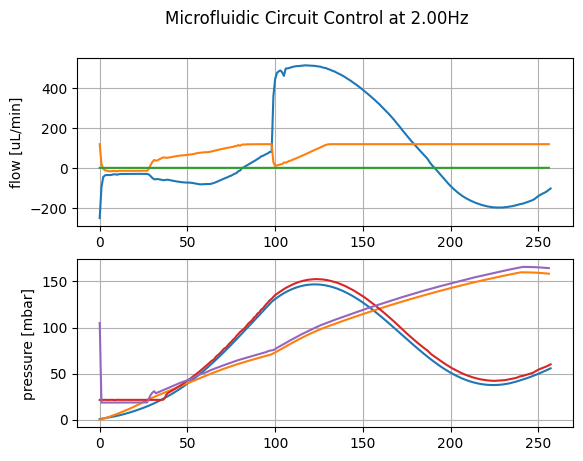

In [58]:
print(flow_list)
print(cont_pressure_list)
print(real_pressure_list,"\n")


plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
plt.subplot(2,1,1)
plt.plot(flow_list[0])
plt.plot(flow_list[1])
plt.plot(flow_list[2])
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list[0])
plt.plot(cont_pressure_list[1])
plt.plot(cont_pressure_list[2])
plt.plot(real_pressure_list[0])
plt.plot(real_pressure_list[1])
plt.plot(real_pressure_list[2])
plt.ylabel('pressure [mbar]')
plt.show() 

In [ ]:
#Tuning

period = 0.
experiment_t = 60
start_t = time.time()
last_t = start_t
active_channels = [1,2]
eqb_d = 10
col_t = 20
K_p = [0.03,0.03] #Tune the proportional component
K_i = 0 #Tune the integral component 
FlowScale = [100,30,50,80,100]

flow_list, fr, pr_control, cont_pressure_list, real_pressure_list = [[],[],[],[]],[[],[],[],[]],[0,0,0,0],[[],[],[],[]],[[],[],[],[]]
I = [0,0,0,0]
active_t = 120


for flow in FlowScale:
    print("\n\nSet Flow rate",flow,"\n\n")
    start_t = time.time()
    last_t = start_t
    collection = False
    active_t = 120
    t = 0
    fr_perc_error = [[],[],[],[]]
    while True:
        for i, channel in enumerate(active_channels):
            #Read Flow Rate
            fr[i] = get_sensor_data(channel)[0]
            flow_list[i].append(fr[i])
            fr_error = fr[i]-flow
            fr_perc_error[i].append(abs(fr_error/flow))
            #Read Pressure
            pr = get_pressure_data(channel)[0]
            real_pressure_list[i].append(pr) 
            #Calculate Correction
            I[i] = I[i] + K_i*fr_error*(period)
            adjustment =  fr_error*K_p[i] + I[i]
            pr_control[i] = pr_control[i] - adjustment 
            cont_pressure_list[i].append(pr_control[i])
            set_pressure(channel,pr_control[i])
        fr[2] = get_sensor_data(3)[0]
        flow_list[2].append(fr[2])
        print("Ch1-FR {:.2f}".format(fr[0]),"Ch2-FR {:.2f}".format(fr[1]),"Ch3-FR {:.2f}".format(fr[2]))

        if t > eqb_d*2:
            #print(np.max((fr_perc_error[i])[(t-eqb_d*2):t]))
            if np.max((fr_perc_error[i])[(t-eqb_d*2):t]) < 0.1 and collection == False:
                print(np.max((fr_perc_error[i])[(t-eqb_d*2):t]))
                print("Equilibriation time ",t/2,"s")
                print("Beginning Collection\n\n\n")
                #Move to well position
                collection = True
                K_p = 0
                start_t = time.time()
                active_t = col_t
            elif np.max((fr_perc_error[i])[(t-eqb_d*2):t]) > 0.1 and collection == True:
                print("Flow rate condition fail")

        if collection == True:
            K_p += 0.1


        if (time.time() - start_t) > active_t:
            break
        # Wait until desired period time
        sleep_t = period - (time.time() - last_t)
        if sleep_t > 0:
            time.sleep( sleep_t )
        last_t = time.time() # And update the last time 
        t = t+1
    
    
set_pressure(1,0)
set_pressure(2,0)
print(flow_list)
print(cont_pressure_list)
print(real_pressure_list,"\n")


plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))
plt.subplot(2,1,1)
plt.plot(flow_list[0])
plt.plot(flow_list[1])
plt.plot(flow_list[2])
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot(cont_pressure_list[0])
plt.plot(cont_pressure_list[1])
plt.plot(cont_pressure_list[2])
plt.plot(real_pressure_list[0])
plt.plot(real_pressure_list[1])
plt.plot(real_pressure_list[2])
plt.ylabel('pressure [mbar]')
plt.show()    

In [40]:
import time

# PID constants
Kp = 0
Ki = 0
Kd = 0
prev_error = 0

# Relay method to determine ultimate gain and oscillation period
def relay_method(setpoint, chan):
    Kp = 0
    prev_error = 0
    amplitude = 30
    oscillation_period = 0
    start_time = time.time()
    press = 20
    while oscillation_period == 0:
        flow = get_sensor_data(channel)[0]
        error = setpoint - flow 
        output = Kp * error 
        print(flow,output)
        if output > amplitude:
            oscillation_period = time.time() - start_time
        press = press + output
        set_pressure(chan,press)
        Kp = Kp +0.0002
        time.sleep(0.01)
    Ku = 4 * amplitude / (3.14159 * 2)
    return Ku, oscillation_period

# Ziegler-Nichols tuning method
def ZN_autotune(Ku, oscillation_period):
    Kp = 0.6 * Ku
    Ki = 1.2 * Ku / oscillation_period
    Kd = 3 * Ku * oscillation_period / 40
    return Kp, Ki, Kd



# Perform Ziegler-Nichols tuning
for chan in active_channels:
    Ku, oscillation_period = relay_method(50,chan)
    Kp, Ki, Kd = ZN_autotune(Ku, oscillation_period)
    print("Tuned PID constants: Kp={}, Ki={}, Kd={}".format(Kp, Ki, Kd))


-1100.0 0.0
-1096.2413793103449 0.229248275862069
-881.3793103448276 0.37255172413793103
-640.7931034482758 0.41447586206896553
-479.0344827586207 0.4232275862068966
-364.2758620689655 0.41427586206896555
-283.2758620689655 0.3999310344827587
-228.79310344827587 0.39031034482758625
-188.17241379310346 0.3810758620689656
-160.48275862068965 0.3788689655172415
-142.79310344827587 0.3855862068965518
-131.89655172413794 0.4001724137931036
-124.6896551724138 0.4192551724137932
-119.24137931034483 0.4400275862068967
-114.03448275862068 0.4592965517241381
-109.0 0.47700000000000015
-104.48275862068965 0.494344827586207
-101.10344827586206 0.5137517241379311
-97.75862068965517 0.5319310344827588
-95.51724137931035 0.5529655172413795
-93.27586206896552 0.5731034482758622
-91.20689655172414 0.5930689655172414
-89.82758620689656 0.615241379310345
-88.82758620689656 0.6386068965517242
-88.03448275862068 0.6625655172413792
-87.13793103448276 0.6856896551724136
-86.51724137931035 0.7098896551724136


KeyboardInterrupt: 

In [32]:
auto_tune([1,2])

Auto Tune
-54.310344827586206
-0.0
-54.241379310344826
-24.430439952438096
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
1
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0
120.0
-0.0

KeyboardInterrupt: 